In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from src.graphSAGE import GraphSage
from data.cora.cora import CoraData
from src.utils.sampling import multihop_sampling

In [2]:
INPUT_DIM = 1433
HIDDEN_DIM = [128, 7]
NUM_NEIGHBORS_LIST = [10, 10]
BTACH_SIZE = 16
EPOCHS = 200
NUM_BATCH_PER_EPOCH = 20
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
assert len(HIDDEN_DIM) == len(NUM_NEIGHBORS_LIST)

In [5]:
data = CoraData().data
x = data.x / data.x.sum(1, keepdims=True)

train_index = np.where(data.train_mask)[0]
train_label = data.y
test_index = np.where(data.test_mask)[0]

/notebooks/data/cora/weights.pkl
Using Cached file: /notebooks/data/cora/weights.pkl


In [6]:
model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
                  num_neighbors_list=NUM_NEIGHBORS_LIST).to(DEVICE)
print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


GraphSage(
  in_features=1433, num_neighbors_list=[10, 10]
  (gcn): ModuleList(
    (0): SageGCN(
      in_features=1433, out_features=128, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=1433, out_features=128, aggr_method=mean)
    )
    (1): SageGCN(
      in_features=128, out_features=7, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=128, out_features=7, aggr_method=mean)
    )
  )
)


In [12]:
def train(epochs):
    accuracy = []
    model.train()
    for e in range(epochs):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
            batch_src_label = torch.from_numpy(train_label[batch_src_index]).long().to(DEVICE)
            batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
            batch_sampling_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in batch_sampling_result]
            batch_train_logits = model(batch_sampling_x)
            loss = criterion(batch_train_logits, batch_src_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if  e%10 == 0:
            print("Epoch {:03d} Loss: {:.4f}".format(e, loss.item()))
        accuracy.append(test())
    return accuracy


def test():
    model.eval()
    with torch.no_grad():
        test_sampling_result = multihop_sampling(test_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
        test_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in test_sampling_result]
        test_logits = model(test_x)
        test_label = torch.from_numpy(data.y[test_index]).long().to(DEVICE)
        predict_y = test_logits.max(1)[1]
        accuracy = torch.eq(predict_y, test_label).float().mean().item()
        return accuracy
        
accuracy = train(EPOCHS)

Epoch 000 Loss: 1.6535
Epoch 010 Loss: 0.0937
Epoch 020 Loss: 0.0312
Epoch 030 Loss: 0.0087
Epoch 040 Loss: 0.0064
Epoch 050 Loss: 0.0041
Epoch 060 Loss: 0.0047
Epoch 070 Loss: 0.0020
Epoch 080 Loss: 0.0020
Epoch 090 Loss: 0.0016
Epoch 100 Loss: 0.0008
Epoch 110 Loss: 0.0007
Epoch 120 Loss: 0.0007
Epoch 130 Loss: 0.0004
Epoch 140 Loss: 0.0007
Epoch 150 Loss: 0.0005
Epoch 160 Loss: 0.0004
Epoch 170 Loss: 0.0002
Epoch 180 Loss: 0.0003
Epoch 190 Loss: 0.0003


Text(0.5, 1.0, '0.76500004529953')

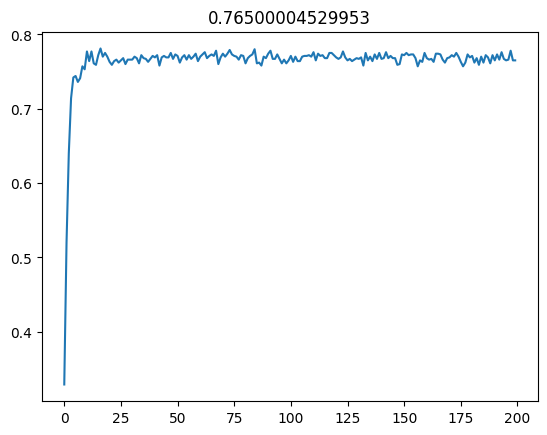

In [13]:
plt.plot(accuracy)
plt.title(accuracy[-1])